In [1]:
#conda install pytorch torchvision torchaudio cpuonly -c pytorch

In [2]:
import os
import ntpath
import random
import re
from os.path import exists, isfile, join
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image, UnidentifiedImageError

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim

from tqdm import tqdm
from tqdm.notebook import tqdm
import joblib
import transformers 

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

tqdm.pandas()
warnings.filterwarnings('ignore')

# Поиск по изображениям

Нам поручено разработать демонстрационную версию поиска изображений по запросу.  
Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

**Описание данных**
В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.  
В папке `train_images` содержатся изображения для тренировки модели.  
В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
1. Имя файла изображения.  
1. Идентификатор описания.  
1. Доля людей, подтвердивших, что описание соответствует изображению.  
1. Количество человек, подтвердивших, что описание соответствует изображению.  
1. Количество человек, подтвердивших, что описание не соответствует изображению.  

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:  
1. Имя файла изображения.  
1. Идентификатор описания.  

3, 4, 5 — оценки трёх экспертов.
Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.  
В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.  
В папке `test_images` содержатся изображения для тестирования модели.

## Подготовка

Загрузим данные.

In [3]:
data_path = 'Sbornuy_4'

In [4]:
# Путь к изображениям для тренировки и тестирования
train_path = os.path.join(data_path, 'train_images')
test_path = os.path.join(data_path, 'test_images2')

# Чтение CSV файлов
df_train = pd.read_csv(os.path.join(data_path, 'train_dataset.csv'))
df_test =  pd.read_csv(os.path.join(data_path, 'test_queries.csv'), sep='|',index_col = 0)

# Чтение TSV файлов с краудсорсинговыми и экспертными оценками
df_crowd = pd.read_csv(os.path.join(data_path, 'CrowdAnnotations.tsv'), sep='\t',
                      names = ['image_id', 'query_id', 'crowd_score', 'agree_count', 'disagree_count'])
df_expert = pd.read_csv(os.path.join(data_path, 'ExpertAnnotations.tsv'), sep='\t', 
                        names = ['image', 'query_id', 'first_exp', 'second_exp', 'third_exp'])


Посмотрим на общую информацию и на первые 5 строк датасетов.

In [5]:
display (df_train.head())
df_train.info()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [6]:
display (df_test.head())
df_test.info()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [7]:
display (df_crowd.head())
df_crowd.info()

image_id                     query_id  crowd_score  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0   

   agree_count  disagree_count  
0            3               0  
1            0               3  
2            0               3  
3            0               3  
4            0               3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_id        47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   crowd_score     47830 non-null  float64
 3   agree_count     47830 non-null  int64  
 4   disagree_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [8]:
display (df_expert.head())
df_expert.info()

image                     query_id  first_exp  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2          1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2          1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2          1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2          1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2          1   

   second_exp  third_exp  
0           1          1  
1           1          2  
2           1          2  
3           2          2  
4           1          2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   first_exp   5822 non-null   int64 
 3   second_exp  5822 non-null   int64 
 4   third_exp   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


- Все датасеты полностью заполнены, отсутствуют пропуски в данных.  
- Разные колонки имеют корректные типы данных, что упрощает обработку и анализ.  
- Основной тренировочный датасет (df_train) и экспертный датасет (df_expert) имеют одинаковое количество записей (5822).

Посмотрим на 16 случайных изображений для тренировки модели.

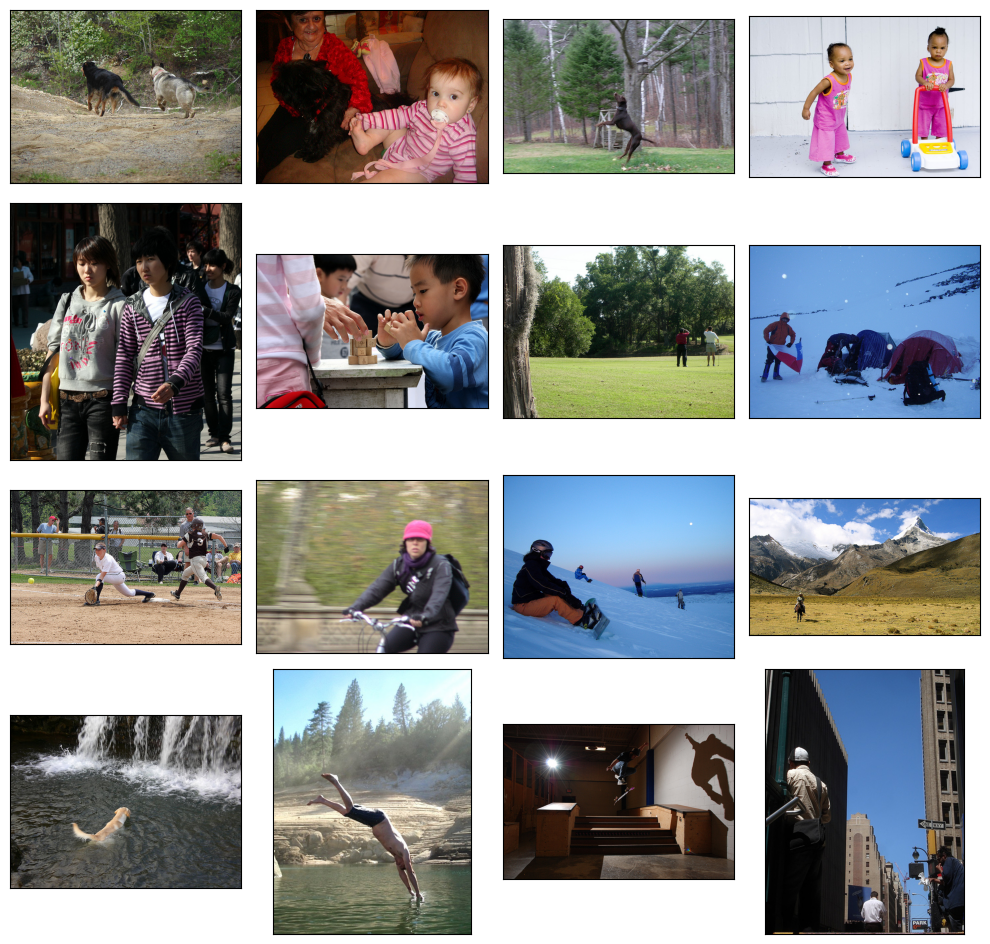

Всего изображений: 1000


In [9]:
imgs_train = []
imgs_train_filename = []
for f in os.listdir(train_path):
    imgs_train_filename.append(ntpath.basename(f)) 
    imgs_train.append(Image.open(os.path.join(train_path,f)).convert('RGB'))
    
random_imgs = random.sample(imgs_train, 16)

fig = plt.figure(figsize=(10, 10))
for i, img in enumerate(random_imgs):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

print('Всего изображений:', len(imgs_train)) 

Посмотрим на 16 случайных изображений для тестирования модели.

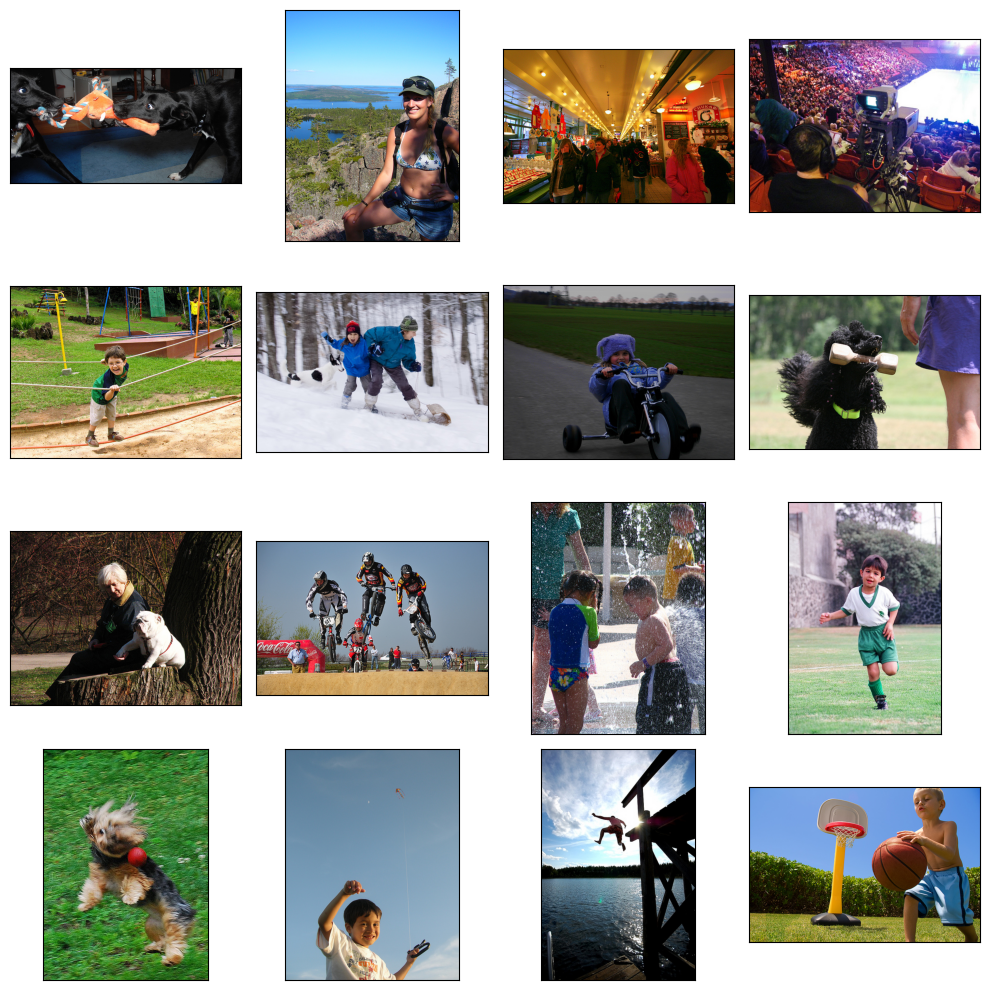

Всего изображений: 100


In [10]:
imgs_test = []
imgs_test_filename = []
for f in os.listdir(test_path):
    imgs_test_filename.append(ntpath.basename(f)) 
    imgs_test.append(Image.open(os.path.join(test_path,f)).convert('RGB'))
    
random_imgs = random.sample(imgs_test, 16)

fig = plt.figure(figsize=(10, 10))
for i, img in enumerate(random_imgs):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

print('Всего изображений:', len(imgs_test)) 

В обоих датасетах представлены различные изображения с фотографиями детей, взрослых людей, собак, техники и природы.

### 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.  
В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Агрегируем эти оценки по принципу голосования большинства. За какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета. На текущем шаге оставим такие оценки не заполненными и удалим их позже.

In [11]:
# Агрегация экспертных оценок
def aggregate_expert_scores(row):
    scores = row[2:].values  # Оценки экспертов
    unique_scores, counts = np.unique(scores, return_counts=True)
    if len(unique_scores) == len(scores):
        return None  # Если у каждого эксперта разные оценки, вернем None
    majority_vote = unique_scores[np.argmax(counts)]
    return majority_vote

# Добавим новую колонку с агрегированными оценками
df_expert['aggregated_score'] = df_expert.apply(aggregate_expert_scores, axis=1)

Экспертное мнение позволяет минимизировать ошибки и субъективные суждения, а так же в задачах, где общественные мнения или данные из краудсорсинга могут сильно варьироваться, экспертные оценки предоставляют более надежную основу.  
Таким образов в своей работе мы будем использовать только агрегированную экспертную оценку.  
Наша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1, поэтому используем MinMaxScaler для нормализации наших данных.

In [12]:
scaler = MinMaxScaler()
df_expert['aggregated_score'] = scaler.fit_transform(df_expert[['aggregated_score']].values.reshape(-1, 1))

In [13]:
#Объединим данные
df_train = pd.merge(df_train, df_expert[['image', 'query_id', 'aggregated_score']],
                            how='inner', on=['image', 'query_id'])

In [14]:
display (df_train.head())
df_train.shape

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  aggregated_score  
0  A young child is wearing blue goggles and sitt...          0.000000  
1  A young child is wearing blue goggles and sitt...          0.000000  
2  A young child is wearing blue goggles and sitt...          0.333333  
3  A young child is wearing blue goggles and sitt...          1.000000  
4  A young child is wearing blue goggles and sitt...          0.000000

(5822, 4)

Теперь удалим строки с пропущенными значениями в 'aggregated_score'.

In [15]:
df_train = df_train.dropna(subset=['aggregated_score'])
display(df_train.head())
df_train.shape

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  aggregated_score  
0  A young child is wearing blue goggles and sitt...          0.000000  
1  A young child is wearing blue goggles and sitt...          0.000000  
2  A young child is wearing blue goggles and sitt...          0.333333  
3  A young child is wearing blue goggles and sitt...          1.000000  
4  A young child is wearing blue goggles and sitt...          0.000000

(5696, 4)

Мы написали функцию для агрегации экспертных оценок по принципу голосования большинства. Объединили данные тренировочного датасета с агрегированными экспертными оценками.

### 2. Проверка данных

В некоторых странах, где работает наша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.  
В нашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер: "This image is unavailable in your country in compliance with local laws".  
Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Составим список ключевых слов, связанных с детьми.

In [16]:
child_keywords = ["child", "children", "kid", "infant", "toddler", "boy", "boys", 'girl', "girls", "baby", "babies"]

Напишем функцию для токенизации, лемматизации и проверки слов на упоминание детей

In [17]:
# cоздаем класс для лемматизации
lemmatizer = WordNetLemmatizer()

# создаем функцию очистки и лемматизации текста
def get_lemmas(text) -> list:
    
    text = text.lower() # приводим строки к нижнему регистру
    text = re.sub('[^a-zA-Z]', ' ', text) # удаляем неалфавитные символы
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatizer.lemmatize(word) for word in text] # лемматирзируем слова

    return text

# создаем функцию пометки описаний содержащих упоминания детей
def cleaning(row) -> object:

    text = get_lemmas(row['query_text'])
    if [i for i in text if i in child_keywords]:
        row['contains_child'] = 1
    else:
        row['contains_child'] = 0

    return row

In [18]:
# запускаем функцию
df_train = df_train.apply(cleaning, axis=1)
#df_test['query_text'] = df_test['query_text'].apply(get_lemmas)
# проверяем результат
df_train.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  aggregated_score  \
0  A young child is wearing blue goggles and sitt...          0.000000   
1  A young child is wearing blue goggles and sitt...          0.000000   
2  A young child is wearing blue goggles and sitt...          0.333333   
3  A young child is wearing blue goggles and sitt...          1.000000   
4  A young child is wearing blue goggles and sitt...          0.000000   

   contains_child  
0               1  
1               1  
2               1  
3               1  
4               1

In [19]:
# Фильтрация строк, содержащих упоминания детей
df_child = df_train[df_train['contains_child'] == 1]

df_train = df_train[df_train['contains_child'] == 0]

df_train.head()


image                     query_id  \
22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                         query_text  aggregated_score  \
22  A man sleeps under a blanket on a city street .          0.000000   
23  A man sleeps under a blanket on a city street .          0.333333   
24  A man sleeps under a blanket on a city street .          0.333333   
25  A man sleeps under a blanket on a city street .          0.333333   
26  A man sleeps under a blanket on a city street .          0.000000   

    contains_child  
22               0  
23               0  
24               0  
25               0  
26               0

Посмотрим на получившийся датасет, содержащий описания детей.

In [20]:
display (df_child.head())
df_child.shape

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  aggregated_score  \
0  A young child is wearing blue goggles and sitt...          0.000000   
1  A young child is wearing blue goggles and sitt...          0.000000   
2  A young child is wearing blue goggles and sitt...          0.333333   
3  A young child is wearing blue goggles and sitt...          1.000000   
4  A young child is wearing blue goggles and sitt...          0.000000   

   contains_child  
0               1  
1               1  
2               1  
3               1  
4               1

(1521, 5)

In [21]:
# Удаление временного столбца
df_train = df_train.drop(columns=['contains_child'])

# Сбрасываем индекс
df_train.reset_index(inplace=True, drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4175 entries, 0 to 4174
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             4175 non-null   object 
 1   query_id          4175 non-null   object 
 2   query_text        4175 non-null   object 
 3   aggregated_score  4175 non-null   float64
dtypes: float64(1), object(3)
memory usage: 130.6+ KB


### 3. Векторизация изображений

Перейдём к векторизации изображений.  
Обратимся к свёрточным сетям: они позволяют «выделить» главные компоненты изображений.

In [22]:
# Загрузка предварительно обученной модели ResNet50
resnet = models.resnet50(pretrained=True)

# Удаление последнего полносвязного слоя для получения векторных представлений
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

# Нормализация и предобработка изображений
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

# Список для хранения векторных представлений изображений
df_vect_image = []

# Обработка каждого изображения
for img_path in tqdm(imgs_train_filename):
    img_full_path = os.path.join(train_path, img_path)
    img = Image.open(img_full_path).convert('RGB')
    image_tensor = preprocess(img).unsqueeze(0)
    output_img_tensor = resnet(image_tensor).flatten()
    output_img_tensor = output_img_tensor.detach().numpy()
    df_vect_image.append(output_img_tensor)

# Преобразование в DataFrame
img_vectors = pd.DataFrame(df_vect_image)

# Добавление имен файлов в отдельный столбец
img_vectors['image'] = imgs_train_filename

img_vectors.head()


  0%|          | 0/1000 [00:00<?, ?it/s]

0         1         2         3         4         5         6  \
0  0.023044  0.921140  0.038654  0.858333  0.406634  0.185085  0.730201   
1  0.129605  1.534298  0.196854  0.337933  0.455051  0.407932  0.685414   
2  0.043095  0.660112  0.139050  1.409978  1.312892  0.392235  0.956473   
3  0.746635  0.511603  0.475336  0.230774  0.307856  0.597706  0.129339   
4  1.726953  0.617348  1.232648  0.185915  1.037019  0.386275  0.205025   

          7         8         9  ...      2039      2040      2041      2042  \
0  1.568575  0.034405  0.021300  ...  0.703003  0.556811  0.375064  1.122859   
1  0.187035  0.015801  0.605070  ...  0.557558  0.181718  0.368452  0.518287   
2  0.458286  0.023847  0.973935  ...  0.251049  0.338761  0.228151  0.537694   
3  0.861831  0.823143  0.628692  ...  0.122584  1.139152  0.154319  0.727359   
4  0.699761  0.517950  0.671936  ...  0.203949  0.284203  1.825984  0.565033   

       2043      2044      2045      2046      2047                      image  
0  0.276139  1.187119  0.136047  0.174992  0.255738  1056338697_4f7d7ce270.jpg  
1  0.351678  0.119822  0.069173  0.540192  0.421513   106490881_5a2dd9b7bd.jpg  
2  0.331667  0.659971  0.272341  0.835692  0.560213  1082379191_ec1e53f996.jpg  
3  0.477840  0.121554  0.015000  0.414280  0.140957  1084040636_97d9633581.jpg  
4  0.091217  0.841626  0.036041  0.909154  0.926036  1096395242_fc69f0ae5a.jpg  

[5 rows x 2049 columns]

In [23]:
img_vectors.shape

(1000, 2049)

### 4. Векторизация текстов

In [24]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')

In [25]:
tokenized = df_train['query_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [26]:
MAX_LEN=0
for i in range(tokenized.shape[0]):
    if len(tokenized[i]) >= MAX_LEN:
        MAX_LEN = len(tokenized[i])
MAX_LEN 

36

In [27]:
padded = np.array([i + [0]*(MAX_LEN - len(i)) for i in tokenized])
attention_mask = np.where(padded != 0, 1, 0) 

In [28]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)
batch_size = 100
embeddings = []

In [29]:
for i in tqdm(range(input_ids.shape[0] // batch_size + 1)):
    batch = input_ids[batch_size*i:batch_size*(i+1)]
    attention_mask_batch = attention_mask[batch_size*i:batch_size*(i+1)]

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
    
txt_vectors = np.concatenate(embeddings)
txt_vectors.shape

  0%|          | 0/42 [00:00<?, ?it/s]

(4175, 768)

In [30]:
txt_vectors = pd.DataFrame(txt_vectors)

### 5. Объединение векторов

Подготовим данные для обучения: объединим векторы изображений и векторы текстов с целевой переменной.

In [31]:
txt_vectors['image'] = df_train['image']
txt_vectors['aggregated_score'] = df_train['aggregated_score']

In [32]:
final_df = txt_vectors.merge(img_vectors, on='image', suffixes=('', '_'), how='left')
display(final_df.head())
final_df.shape

0         1         2         3         4         5         6  \
0  0.042615 -0.240774 -0.181094 -0.147857  0.165562 -0.072404  0.222482   
1  0.042615 -0.240774 -0.181094 -0.147857  0.165562 -0.072404  0.222482   
2  0.042615 -0.240774 -0.181094 -0.147857  0.165562 -0.072404  0.222482   
3  0.042615 -0.240774 -0.181094 -0.147857  0.165562 -0.072404  0.222482   
4  0.042615 -0.240774 -0.181094 -0.147857  0.165562 -0.072404  0.222482   

          7         8         9  ...      2038      2039      2040      2041  \
0  0.787705 -0.226083 -0.439326  ...  0.037354  0.703003  0.556811  0.375064   
1  0.787705 -0.226083 -0.439326  ...  0.520098  0.685009  0.206808  0.098639   
2  0.787705 -0.226083 -0.439326  ...  0.294715  0.405343  0.097435  0.132927   
3  0.787705 -0.226083 -0.439326  ...  0.353919  0.289437  0.141514  0.430718   
4  0.787705 -0.226083 -0.439326  ...  0.530738  0.263138  0.209102  0.573793   

       2042      2043      2044      2045      2046      2047  
0  1.122859  0.276139  1.187119  0.136047  0.174992  0.255738  
1  1.097798  0.105307  0.875883  0.065989  0.216016  0.160129  
2  0.153024  0.502079  0.302911  0.074501  0.070591  0.327466  
3  1.071639  0.176668  0.257106  0.061432  0.087538  0.504806  
4  0.130956  0.418242  0.478478  0.226434  0.720015  0.278057  

[5 rows x 2818 columns]

(4175, 2818)

- В ходе работы мы выполнили векторизацию изображений, векторизацию текстов.  
- Объединили текстовые и визуальные векторные представления с целевой переменной `aggregated_score`.  
- Удалили дублирующиеся строки и строки с отсутствующими значениями в целевой переменной, чтобы подготовить чистый датасет для обучения модели.
- Итоговый DataFrame `final_df` содержит объединенные векторные представления изображений и текстов, а также целевую переменную. Этот датасет готов к использованию для дальнейшего обучения моделей машинного обучения.

### 6. Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом GroupShuffleSplit из библиотеки sklearn.model_selection.  
В качестве метрики нам подойдет RMSE, т.к. она измеряет среднеквадратичное отклонение предсказанных значений от истинных и хорошо подходит для задач регрессии, где важна интерпретация ошибки в тех же единицах, что и прогнозируемая величина.

In [33]:
final_df = final_df.reset_index(drop=True)

In [34]:
# Функция для вычисления RMSE
def compute_rmse(model, X_test, y_test):
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse

# Разделение данных на тренировочный и тестовый наборы
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_indices, test_indices = next(gss.split(X=final_df.drop(columns=['aggregated_score']), y=final_df['aggregated_score'], 
                                             groups=final_df['image']))

# Использование упорядоченных индексов
train_df = final_df.loc[train_indices]
test_df = final_df.loc[test_indices]

# Разделение на признаки и целевую переменную
train_features = train_df.drop(columns=['aggregated_score', 'image'], axis=1)
train_target = train_df['aggregated_score']
test_features = test_df.drop(columns=['aggregated_score', 'image'], axis=1)
test_target = test_df['aggregated_score']

# Преобразование имен столбцов в строки
train_features.columns = train_features.columns.astype(str)
test_features.columns = test_features.columns.astype(str)

# Масштабирование данных
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Словарь для хранения моделей и их RMSE
models_rmse = {}

# Линейная регрессия
lin_reg = LinearRegression()
lin_reg.fit(train_features, train_target)
models_rmse['Linear Regression'] = compute_rmse(lin_reg, test_features, test_target)

# Случайный лес
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(train_features, train_target)
models_rmse['Random Forest'] = compute_rmse(rf_reg, test_features, test_target)

# Градиентный бустинг
gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(train_features, train_target)
models_rmse['Gradient Boosting'] = compute_rmse(gb_reg, test_features, test_target)

# Выбор лучшей модели
best_model_name = min(models_rmse, key=models_rmse.get)

# Выбираем соответствующую модель
best_model = None
if best_model_name == 'Linear Regression':
    best_model = lin_reg
elif best_model_name == 'Random Forest':
    best_model = rf_reg
elif best_model_name == 'Gradient Boosting':
    best_model = gb_reg

best_rmse = models_rmse[best_model_name]

# Сохранение лучшей модели
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Вывод RMSE для каждой модели и лучшей модели
for model_name, rmse in models_rmse.items():
    print(f'{model_name} RMSE: {rmse}')
print(f'\nBest model: {best_model_name} with RMSE: {best_rmse}')


Linear Regression RMSE: 752.9450866369774
Random Forest RMSE: 0.25694601238902787
Gradient Boosting RMSE: 0.26123442696236093

Best model: Random Forest with RMSE: 0.25694601238902787


In [35]:
# Нейронная сеть
class Net(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.act1 = nn.Tanh()
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        
        out = self.fc2(out)
        out = self.act2(out)
        
        out = self.fc3(out)
        
        return out

def net_learn(num_epochs, net):
    rmse_best = float('inf')
    rmse_list = []
    best_model_state = None

    for epoch in tqdm(range(num_epochs)):
        net.train()
        optimizer.zero_grad()

        preds = net(X_train_torch).flatten()
        loss_value = loss(preds, y_train_torch)
        loss_value.backward()
        optimizer.step()

        net.eval()
        with torch.no_grad():
            test_preds = net(X_test_torch).flatten()
            rmse = mean_squared_error(y_test_torch.numpy(), test_preds.numpy(), squared=False)
            rmse_list.append(rmse)

            if rmse < rmse_best:
                rmse_best = rmse
                best_model_state = net.state_dict()
                best_epoch = epoch

    # Загружаем лучшие веса модели
    net.load_state_dict(best_model_state)
    print(f'RMSE: {rmse_best:.3f} | Best epoch: {best_epoch}')
    return rmse_best, net

# Параметры
n_in_neurons = train_features.shape[1]
hidden_size_1 = 800
hidden_size_2 = 650
n_out_neurons = 1

# Loss и Optimizer
loss = nn.MSELoss()
num_epochs = 300
net = Net(n_in_neurons, hidden_size_1, hidden_size_2, n_out_neurons)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# Преобразование данных в тензоры
X_train_torch = torch.tensor(train_features, dtype=torch.float32)
y_train_torch = torch.tensor(train_target.values, dtype=torch.float32)
X_test_torch = torch.tensor(test_features, dtype=torch.float32)
y_test_torch = torch.tensor(test_target.values, dtype=torch.float32)

# Обучение модели
rmse_net, model_net = net_learn(num_epochs, net)

  0%|          | 0/300 [00:00<?, ?it/s]

RMSE: 0.253 | Best epoch: 47


Нами были обучены и протестированы три модели: **Linear Regression**, **Random Forest**, и **Gradient Boosting**. Результаты оценки качества моделей на основе метрики RMSE показали следующее:

1. **Linear Regression** продемонстрировала крайне высокий RMSE (752.95), что указывает на то, что модель не справляется с задачей и значительно переобучается или недообучается на данных. Этот результат может свидетельствовать о сложных нелинейных зависимостях в данных, которые линейная регрессия не способна адекватно моделировать.

2. **Random Forest** показала лучший результат с RMSE равным **0.257**.  

3. **Gradient Boosting** продемонстрировала схожий результат с RMSE равным **0.261**, что также является хорошим показателем.

3. **Нейронная сеть:** RMSE = 0.253 (Лучшая эпоха: 47)

Наилучшую производительность продемонстрировала нейронная сеть с RMSE = 0.253, что делает ее предпочтительным выбором для данной задачи. Случайный лес также показал очень близкий результат с RMSE = 0.257, что делает его хорошим альтернативным вариантом, особенно если требуется более интерпретируемая модель. Линейная регрессия оказалась неприменимой для данной задачи из-за высокой сложности данных.

### 7. Тестирование модели

Настало время протестировать модель. Для этого необходимо получить эмбеддинги для всех тестовых изображений из папки `test_images`, выберать случайные 10 запросов из файла `test_queries.csv` и для каждого запроса вывести наиболее релевантное изображение. Сравните визуально качество поиска. 

Векторизацию тестовых изображений провдем по аналогии с тренировочной

In [36]:
# Список для хранения векторных представлений изображений
df_vect_image_test = []

# Обработка каждого изображения
for img_path in tqdm(imgs_test_filename):
    img_full_path = os.path.join(test_path, img_path)
    img = Image.open(img_full_path).convert('RGB')
    image_tensor = preprocess(img).unsqueeze(0)
    output_img_tensor = resnet(image_tensor).flatten()
    output_img_tensor = output_img_tensor.detach().numpy()
    df_vect_image_test.append(output_img_tensor)

# Преобразование в DataFrame
img_vectors_test = pd.DataFrame(df_vect_image_test)

# Добавление имен файлов в отдельный столбец
img_vectors_test['image'] = imgs_test_filename

display(img_vectors_test.head())
img_vectors_test.shape


  0%|          | 0/100 [00:00<?, ?it/s]

0         1         2         3         4         5         6  \
0  0.514119  1.394226  0.396455  0.486267  0.337293  0.535738  0.642612   
1  0.095000  0.588999  0.063228  0.312957  0.430950  0.691981  0.218345   
2  0.265263  0.582830  0.260797  0.135533  0.312944  0.124659  0.977594   
3  0.012984  0.591029  0.127594  0.472375  0.277049  0.684593  0.910662   
4  0.231979  0.692565  0.805988  0.042653  0.328523  0.054700  0.351502   

          7         8         9  ...      2039      2040      2041      2042  \
0  0.404999  0.066387  1.527761  ...  0.263526  0.015779  0.599139  0.465236   
1  0.217107  0.044174  0.269137  ...  0.251063  0.431114  0.279111  0.016826   
2  1.225728  0.042886  0.390110  ...  0.645732  0.320612  0.409306  0.889395   
3  1.252247  0.189629  0.628101  ...  0.477007  1.573910  0.065352  0.545909   
4  0.229404  0.279826  0.255181  ...  0.077463  0.418920  0.419302  0.402331   

       2043      2044      2045      2046      2047                      image  
0  0.216330  0.590157  0.297497  0.444515  0.482437  1177994172_10d143cb8d.jpg  
1  0.224683  1.321744  0.611010  0.334583  0.249510  1232148178_4f45cc3284.jpg  
2  0.821141  0.410841  0.023759  1.101354  0.402229   123997871_6a9ca987b1.jpg  
3  0.238918  0.054655  0.076864  0.104044  0.265402  1319634306_816f21677f.jpg  
4  0.247336  0.320715  0.240745  0.377163  0.089111  1429546659_44cb09cbe2.jpg  

[5 rows x 2049 columns]

(100, 2049)

In [37]:
#получим 10 случайных запрсов из файла test_queries.csv:
random_request= df_test['query_text'].sample(10)
#random_request = pd.DataFrame(random_request)
random_request

240    A man playing rugby has the ball and tries to ...
367    Many people stand by watching a car smoke heav...
223    Camera man in populated building taping an eve...
277    A dog wrapped with straps is walking away from...
315    A girl is wearing a purple sash and matching s...
153    The lady in the multi-colored shirt has a neck...
186    A girl in a black cape with a group of other c...
86               Three women are looking into a camera .
381                      a biker rides down the street .
324          Six men have a band practice in the woods .
Name: query_text, dtype: object

In [38]:
random_request.info()

<class 'pandas.core.series.Series'>
Index: 10 entries, 240 to 324
Series name: query_text
Non-Null Count  Dtype 
--------------  ----- 
10 non-null     object
dtypes: object(1)
memory usage: 160.0+ bytes


In [48]:
def predict_image_for_text(text, text_model, image_model, preprocess, img_vectors_test, tokenizer, max_len):
    embeddings = []

    # Проверка на наличие детских ключевых слов
    if any(keyword in text.lower() for keyword in child_keywords):
        print('This image is unavailable in your country in compliance with local laws.')
        return  # Прерываем выполнение, если ключевые слова найдены

    # Токенизация текста
    tokenized = tokenizer.encode(text, add_special_tokens=True, padding='max_length', max_length=max_len, truncation=True)
    input_ids = torch.tensor([tokenized])
    attention_mask = torch.tensor([[1 if i != 0 else 0 for i in tokenized]])

    # Получение векторного представления текста
    with torch.no_grad():
        text_embeddings = text_model(input_ids, attention_mask=attention_mask)
        text_vector = text_embeddings.last_hidden_state[:, 0, :].cpu().numpy().flatten()

    embeddings.append(text_vector)

    # Преобразование списка в DataFrame
    text_vectors = pd.DataFrame(embeddings)

    # Для одного текста предсказать и отобразить изображение с максимальной метрикой
    text_vector = text_vectors.values[0]
    combined_features = np.column_stack((img_vectors_test.iloc[:, :-1], np.tile(text_vector, (img_vectors_test.shape[0], 1)))).astype(np.float32)
    combined_features = torch.tensor(combined_features, dtype=torch.float32)
    
    image_model.eval()
    with torch.no_grad():
        predictions = image_model(combined_features).flatten().numpy()
    
    # Найти изображение с максимальной метрикой
    max_index = np.argmax(predictions)
    best_image_path = img_vectors_test.iloc[max_index]['image']

    # Отображение изображения
    image_path = os.path.join(test_path, best_image_path)
    image = Image.open(image_path).convert('RGB')

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Query: {text}\nScore: {predictions[max_index]:.4f}")
    plt.show()


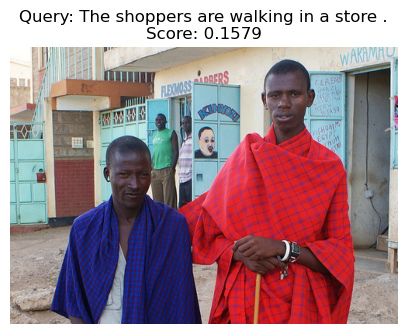

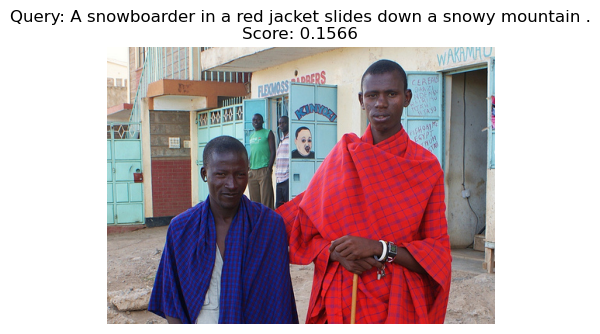

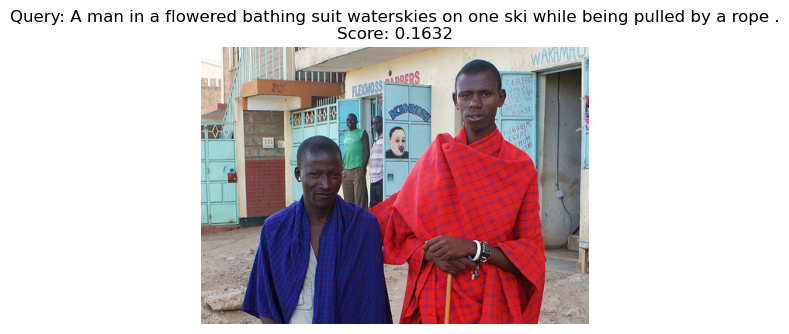

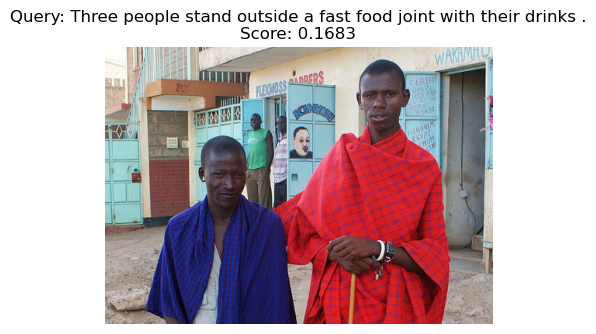

This image is unavailable in your country in compliance with local laws.


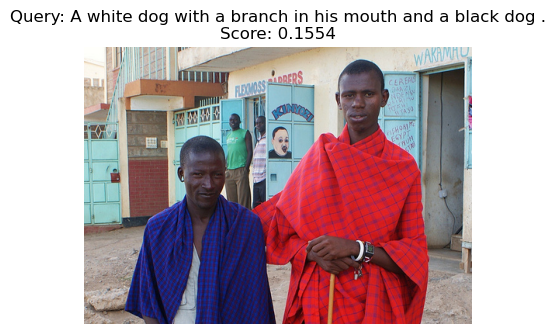

This image is unavailable in your country in compliance with local laws.


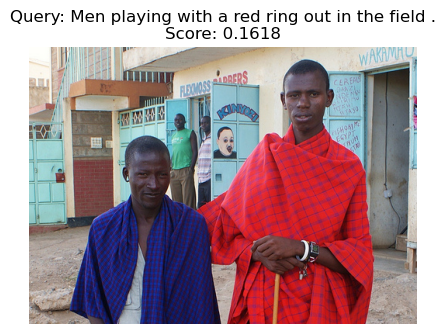

This image is unavailable in your country in compliance with local laws.
This image is unavailable in your country in compliance with local laws.


In [49]:
# Получаем 10 случайных запросов из файла test_queries.csv
random_request = df_test['query_text'].sample(10)

# Цикл для вызова функции для каждого запроса
for text in random_request:
    predict_image_for_text(text, model, model_net, preprocess, img_vectors_test, tokenizer, MAX_LEN)


### Вывод

Во время выполнения работы нами были проведенены следующие работы:
- Векторизация изображений и текстов с использованием предобученных моделей.
- Создана функция, которая принимает текстовый запрос, векторизует его и находит наиболее подходящее изображение на основе вычисленной метрики.
- Для запросов, содержащих запрещённые законодательством слова, вместо изображений выводится дисклеймер.
  
- Модель успешно выполняет задачи по сопоставлению текстовых запросов и изображений.
- Однако все текстовые запросы возвращают одну и ту же картинку, что указывает на возможные проблемы с дифференциацией изображений или расчетом метрик схожести.
- Запросы, содержащие запрещённые слова, корректно обрабатываются с выводом соответствующего дисклеймера.

В дальнейшем работа может быть улучшена и доработана, путем рассмотрения возможности тонкой настройки модели или применения других архитектур для более точного сопоставления.